# Lab #3 Millican

In [4]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pandas as pd

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

## Problem 1)

In our first example we are looking at the temperature reading (meta-data) associated with an experiment. For the experiment to work reliably, the temperature should be at around 12 Kelvin, and if we look at the data it is mostly consistent with 12 Kelvin to within the 0.4 degree precision of the thermometry and the thermal control system (standard deviation). However, there are times when the thermal control system misbehaved and  the temperature was not near 12 K, and in addition there are various glitches in the thermometry that give  anomalously high and low readings (the reading does not match the real temperature). We definitely want to  identify and throw out all the data when the thermal control system was not working (and the temperature was  truly off from nominal). While it is possible to have an error in the thermometry such that the true temperature was fine, and we just had a wonky reading, in an abundance of caution we want to throw those values out too.

To make this a bit concrete, we will simulate a little data. Start by simulating 100k 'good' data points assuming Gaussian fluctations, and because we are playing god adding the following 'bad' datapoints: {10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7}



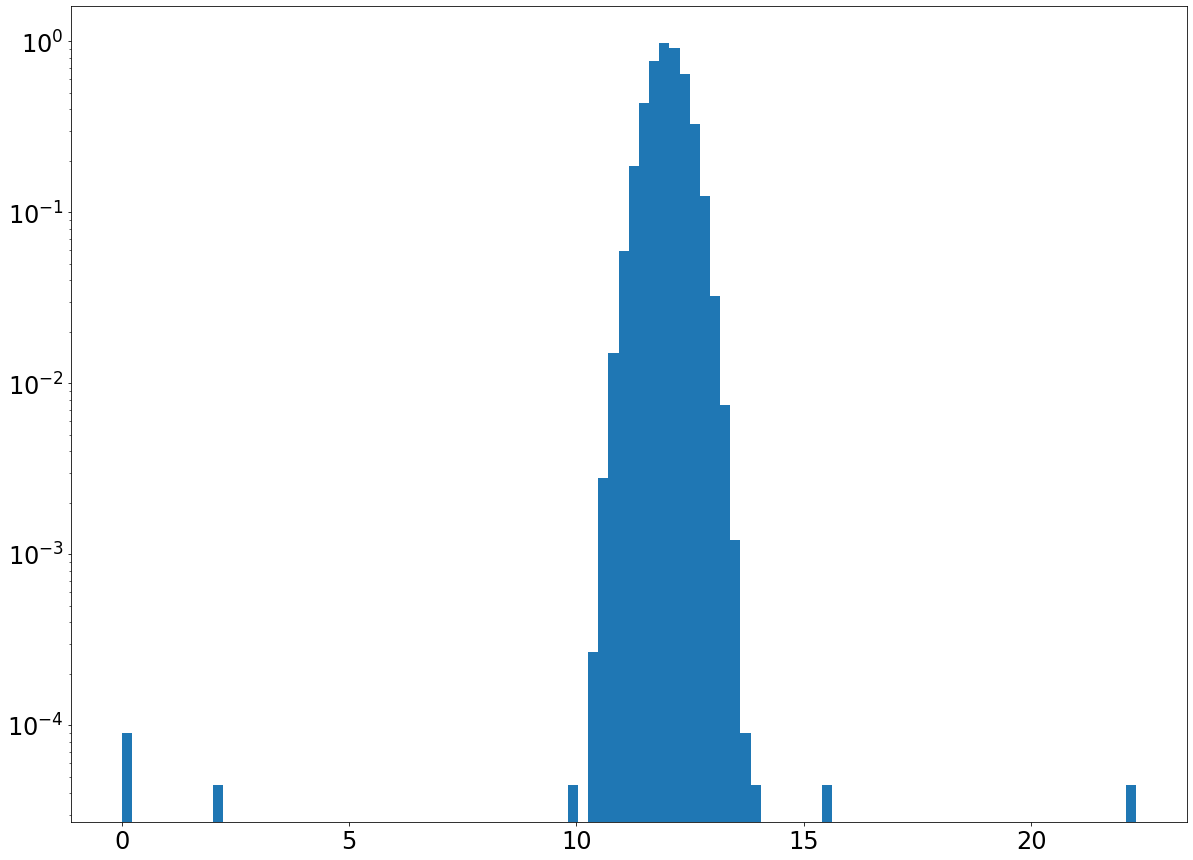

In [20]:
d = np.append(stats.norm.rvs(loc = 12., scale = 0.4, size = 100000), [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])
fig, ax = plt.subplots(1, 1)
ax.hist(d,100, density=True)
plt.tick_params(labelsize = 24)
plt.yscale('log')
#x = np.linspace(4.95,5.05,1000)
#ax.plot(x,stats.norm.pdf(x,loc = 5., scale = 0.01),linewidth = 8,alpha = 0.7)
plt.show()

## A)
Here I will attempt to throw out data points that are considered 'bad'. I will identify bad data points as points that lie outside of the $5\sigma$ points for the distribution.  The statistical question we want to answer is "How much good data did I throw out of contention, and how much bad data did I end up leaving in the set?" I have chosen this question because it will be a good indication of how well I was able remove the unwanted data. 

In terms of math, I am going to use the icdf or ppf function to find the values of the normal distribution that was given (assuming this is relavively the distribution that a Gauss-fit of the whole data set would provide) to find the $5\sigma$ point to the left and right of the data set. Any points outside of this range will be removed. 

In [55]:
data = pd.DataFrame(d, columns=['Data'])
loc=12; scale=.4
prob5sigma = 1/3.5e6
rightbound = stats.norm.ppf(1 - prob5sigma/2, loc, scale)
leftbound = stats.norm.ppf(prob5sigma/2, loc, scale)
new5 = data.query(f'{leftbound} < Data < {rightbound}')
removed5 = data.query(f'{rightbound} < Data < {leftbound}')
print(f'The 5 sigma bounds fall at {leftbound} and {rightbound}, leaving {len(new5)} data points')


The 5 sigma bounds fall at 9.946946166258849 and 14.053053833722277, leaving 100003 data points


There are a total of 100,000 good data points and 8 bad data points. Here is the truth table of what got properly/improperly removed. 


|         | True T (100k) | Bad T (8) |
|---      |---            |---        |
|Test Good| 100,000       |   3       |
| Test Bad|     0         |   5       |



I chose to use the 5 sigma value as my criteria for what data to remove. This left me with no improper ommision but with 3 improper commisions of data points. This still isn't so bad as to say that I didn't remove any good data and I am left with only $\frac{3}{100,000} $ worth of bad data. 

The threshold for which the criteria of bad data has an affect on the number of improper commisions and ommissions. If the threshold is too close to the center of the distribution, too many cood points will be ommitted, but as it lies now there are still 3 bad points making their way into the data. 

In [66]:
data = pd.DataFrame(d, columns=['Data'])
loc=12; scale=.4
prob4sigma = 1 - 0.99994
rightbound = stats.norm.ppf(1 - prob4sigma/2, loc, scale)
leftbound = stats.norm.ppf(prob4sigma/2, loc, scale)
new4 = data.query(f'{leftbound} < Data < {rightbound}')
removed4 = data.query(f'{rightbound} < Data < {leftbound}')
print(f'The 5 sigma bounds fall at {leftbound} and {rightbound}, leaving {len(new4)} data points')


The 5 sigma bounds fall at 10.394875675552619 and 13.605124324447381, leaving 99997 data points


Here is the new truth table for taking data at $4\sigma$

|         | True T (100k) | Bad T (8) |
|---      |---            |---        |
|Test Good| 99,996        |   1       |
| Test Bad|     4         |   7       |



In order to remove all of the 'bad' points you actually have to take the distribution all the way down to roughly a $1.7\sigma$ distribution which removes a significant amount of the data. 

In [69]:
data = pd.DataFrame(d, columns=['Data'])
loc=12; scale=.4
prob17sigma = 1 - 0.91086
rightbound = stats.norm.ppf(1 - prob17sigma/2, loc, scale)
leftbound = stats.norm.ppf(prob17sigma/2, loc, scale)
new17 = data.query(f'{leftbound} < Data < {rightbound}')
removed17 = data.query(f'{rightbound} < Data < {leftbound}')
print(f'The 5 sigma bounds fall at {leftbound} and {rightbound}, leaving {len(new4)} data points')


The 5 sigma bounds fall at 11.32001929654405 and 12.67998070345595, leaving 91164 data points


Here is the new truth table for taking data at $1.7\sigma$ and depending on the significance of ommission vs commission errors, this might be the data set you would want to use. 

|         | True T (100k) | Bad T (8) |
|---      |---            |---        |
|Test Good| 91,164        |   0       |
| Test Bad|     8,836         |   8       |



I have shown above how multiple different thresholds provided different counts of ommission and commission error. 

## Problem 2)
In this example we will be looking for asteroids. If we look at the alignment of stars on subsequent images, they don't perfectly align due to atmospheric and instrumental effects (even ignoring proper motion). The resulting distribution is two dimensional, and for this lab let's assume it is a 2D Gaussian with 1 arcsecond RMS. Or said another way, if I histogram how far all the (stationary) stars appear to have moved I get something like:

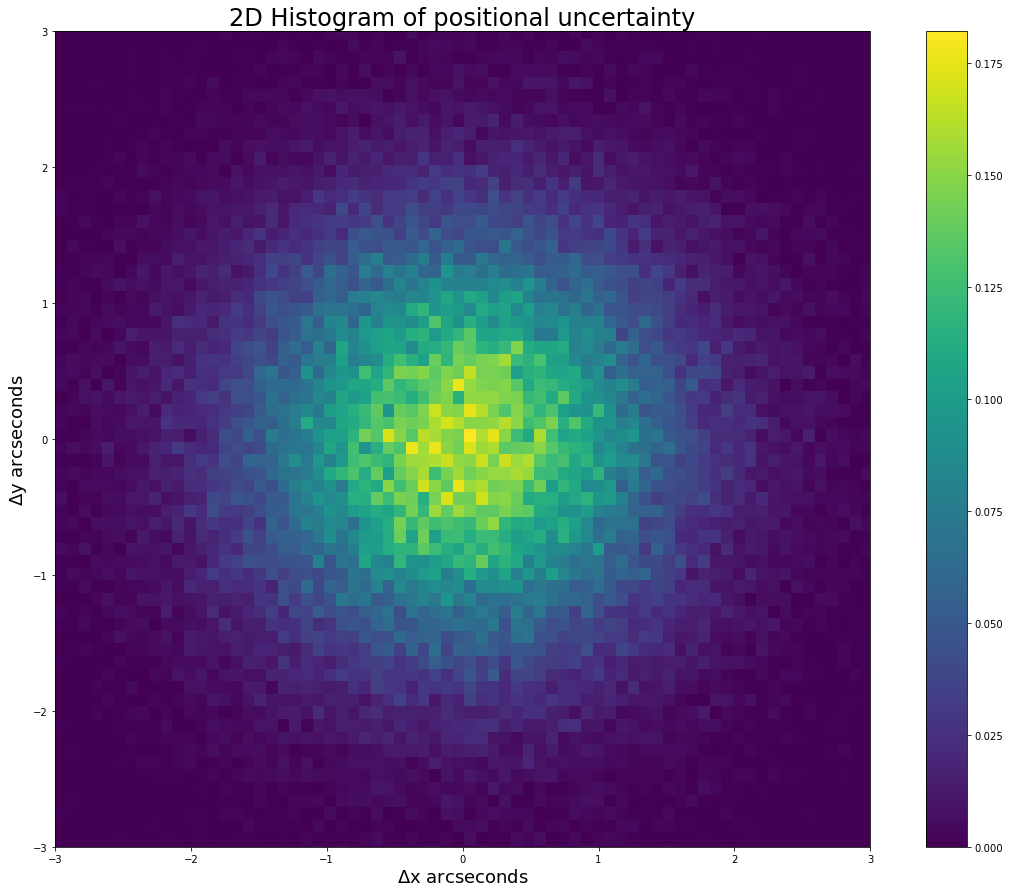

In [73]:
a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty", fontsize = 24)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)
plt.colorbar(h[3], ax=ax)

After a little bit of searching, I was able to find the "Multivariable Normal Distribution" that also has scipy.stats functions associated with it. I will be using this to do my analysis. RMS is just another way to say the Gaussian sigma value. The question we want to answer is where on this distribution (plot), is the $5\sigma$ value? This 'value' will actually appear like a ring in which outside of the ring lies the $\frac{1}{3,500,000}$ portion of the distribution. 

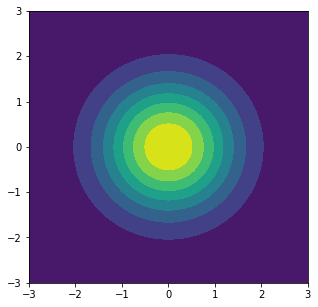

In [115]:
#With a little help from StackOverflow I was able to create the PDF of the function. 
mean = np.array([0, 0])
cov = np.array([[1, 0], [0, 1]])
n = 1000  # Number of samples
delta = 6 / (n - 1)  # Grid spacing

v = np.linspace(-3, 3, n)
xv, yv = np.meshgrid(v, v)
pos = np.empty((n, n, 2))
pos[:, :, 0] = xv
pos[:, :, 1] = yv
pdf = stats.multivariate_normal.pdf(pos, mean, cov)


        # Compare with standard normal distribution
gauss_x = stats.norm.pdf(v, loc=mean[0], scale=cov[0, 0] ** 0.5)
gauss_y = stats.norm.pdf(v, loc=mean[1], scale=cov[1, 1] ** 0.5)

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.contourf(v, v, pdf)


In [112]:
prob5sigma = 1/3.5e6
rightbound = stats.multivariate_normal.ppf(1 - prob5sigma, mean, cov)
leftbound = stats.norm.ppf(prob5sigma/2, loc, scale)
new5 = data.query(f'{leftbound} < Data < {rightbound}')
removed5 = data.query(f'{rightbound} < Data < {leftbound}')
print(f'The 5 sigma bounds fall at {leftbound} and {rightbound}, leaving {len(new5)} data points')


AttributeError: 'multivariate_normal_gen' object has no attribute 'ppf'